In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

## Part 1: Loading Movie Rating Dataset

In [2]:
data = loadmat("./ex8_movies.mat")
Y = data["Y"]
R = data["R"]

Text(0, 0.5, 'Moives')

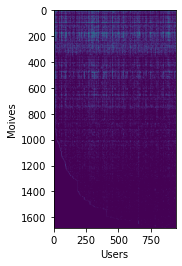

In [3]:
plt.imshow(Y)
plt.xlabel("Users")
plt.ylabel("Moives")

## Part 2: Collaborative Filtering Cost Function

In [4]:
def parseParams(params, num_users, num_movies, num_features):
    assert params.ndim==1
    X_size = (num_movies, num_features)
    theta_size = (num_users, num_features)
    assert len(params) == X_size[0]*X_size[1] + theta_size[0]*theta_size[1]
    X = params[:X_size[0]*X_size[1]].reshape(X_size)
    theta = params[X_size[0]*X_size[1]:].reshape(theta_size)
    return X, theta

In [5]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamda):
    """Collaborative filtering cost function
    """
    X, theta = parseParams(params, num_users, num_movies, num_features)
    J = 0.5 * np.sum(R * (X@theta.T-Y)**2)
    return J

In [6]:
# Test
Params = loadmat("./ex8_movieParams.mat")
X = Params["X"]
Theta = Params["Theta"]
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]
J = cofiCostFunc(np.r_[X.flatten(), Theta.flatten()], Y, R, num_users, num_movies, num_features, 0)
print(f"Cost at loaded parameters:{J}\nThis value should be about 22.22")

Cost at loaded parameters:22.224603725685675
This value should be about 22.22


## Part 3: Collaborative Filtering Gradient

In [7]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamda):
    """Collaborative filtering cost function
    """
    X, theta = parseParams(params, num_users, num_movies, num_features)
    J = 0.5 * np.sum(R * (X@theta.T-Y)**2)
    
    X_grad = ((X@theta.T-Y) * R) @ theta
    theta_grad = ((theta@X.T-Y) * R) @ X
    assert X_grad.shape == X.shape
    assert theta_grad.shape == theta.shape
    grad = np.r_[X_grad.flatten(), theta_grad.flatten()]
    
    return J, grad

## Part 4: Collaborative Filtering Cost Regularization

In [8]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamda):
    """Collaborative filtering cost function
    """
    X, theta = parseParams(params, num_users, num_movies, num_features)
    reg = 0.5 * lamda * (np.sum(np.square(X)) + np.sum(np.square(theta)))
    J = 0.5 * np.sum(R * (X@theta.T-Y)**2) + reg
    
    X_grad = ((X@theta.T-Y) * R) @ theta
    theta_grad = ((theta@X.T-Y.T) * R.T) @ X
    assert X_grad.shape == X.shape
    assert theta_grad.shape == theta.shape
    grad = np.r_[X_grad.flatten(), theta_grad.flatten()]
    
    return J, grad

In [9]:
J, grad = cofiCostFunc(np.r_[X.flatten(), Theta.flatten()], Y, R, num_users, num_movies, num_features, 1.5)
print(f"Cost at loaded parameters (lamda=1.5):{J}\nThis value should be about 31.34")

Cost at loaded parameters (lamda=1.5):31.34405624427422
This value should be about 31.34


## Part 5: Collaborative Filtering Gradient Regularization

In [10]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lamda):
    """Collaborative filtering cost function
    """
    X, theta = parseParams(params, num_users, num_movies, num_features)
    reg = 0.5 * lamda * (np.sum(np.square(X)) + np.sum(np.square(theta)))
    J = 0.5 * np.sum(R * (X@theta.T-Y)**2) + reg
    
    X_grad = ((X@theta.T-Y) * R) @ theta + lamda * X
    theta_grad = ((theta@X.T-Y.T) * R.T) @ X + lamda * theta
    assert X_grad.shape == X.shape
    assert theta_grad.shape == theta.shape
    grad = np.r_[X_grad.flatten(), theta_grad.flatten()]
    
    return J, grad

## Part 6: Entering Rating for a New User

In [11]:
def loadMovieList():
    movieList = []
    with open("./movie_ids.txt", "r", encoding='gbk') as f:
        while True:
            text = f.readline()
            if not text:
                break
            idx, *movieName = text.strip().split(sep=" ")
            movieList.append(" ".join(movieName))
    return movieList

In [12]:
movieList = loadMovieList()

In [13]:
my_ratings = np.zeros(1682)
my_ratings[1] = 4;
my_ratings[98] = 2;
my_ratings[7] = 3;
my_ratings[12]= 5;
my_ratings[54] = 4;
my_ratings[64]= 5;
my_ratings[66]= 3;
my_ratings[69] = 5;
my_ratings[183] = 4;
my_ratings[226] = 5;
my_ratings[355]= 5;

## Part 7: Learning Movie Ratings

In [14]:
data = loadmat("./ex8_movies.mat")
Y = data["Y"]
R = data["R"]
Y = np.c_[Y, my_ratings[:, np.newaxis]]
R = np.c_[R, my_ratings[:, np.newaxis] != 0]

In [22]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
X = np.random.randn(num_movies, num_features)
theta = np.random.randn(num_users, num_features)
initial_parameters = np.r_[X.flatten(), theta.flatten()]
lamda = 10.

In [25]:
result = minimize(cofiCostFunc, x0=initial_parameters, 
                  args=(Y, R, num_users, num_movies, num_features, lamda), jac=True, method="L-BFGS-B")
if result.success:
    params = result.x

## Part 8: Recommendation for You

In [42]:
X, theta = parseParams(params, num_users, num_movies, num_features)
p = X@theta.T
my_prediction =  dict(enumerate(p[:, -1]))

In [46]:
my_prediction = sorted(my_prediction.items(), key=lambda d: d[1], reverse=True)

In [51]:
for i in range(10):
    j = my_prediction[i][0]
    print(movieList[j])

Star Wars (1977)
Good Will Hunting (1997)
Shawshank Redemption, The (1994)
Titanic (1997)
As Good As It Gets (1997)
Schindler's List (1993)
Empire Strikes Back, The (1980)
Wrong Trousers, The (1993)
Usual Suspects, The (1995)
Raiders of the Lost Ark (1981)
